In [11]:
using InvRayTrace
using InvRayTrace: Img
using Omega
using RayTrace
import RayTrace
import RayTrace: ListScene, rgb, msphere, Vec3, Sphere, Scene, render
import GeometryTypes: Point, Vec3

Render at 224 by 224 because

In [12]:
rendersquare(x) = Img(RayTrace.render(x, width = 224, height = 224))

rendersquare (generic function with 1 method)

Define Prior Distribution over Scenes

In [13]:
const nspheres = poisson(3) + 1

"Random Variable over Spheres"
function sphere_(ω)
  msphere(Point(uniform(ω[@id], -6.0, 6.0), uniform(ω[@id], -1.0, 1.0), uniform(ω[@id], -30.0, -10.0)),
          uniform(ω[@id], 1.0, 5.0),
          Vec3(uniform(ω[@id], 0.0, 1.0), uniform(ω[@id], 0.0, 1.0), uniform(ω[@id], 0.0, 1.0)),
          1.0,
          0.0,
          Vec3(0.0, 0.0, 0.0))
end

"Random Variable over scenes"
function scene_(ω)
  spheres = [sphere_(ω[i]) for i = 1:nspheres(ω)]
  base = msphere(Point(0.0, -10004, -20), 10000.0, Vec3(0.20, 0.20, 0.20), 0.0, 0.0, Vec3(0.0, 0.0, 0.0))
  light = msphere(Point(0.0, 20.0, -30), 3.0, zeros(Vec3), 0.0, 0.0, Vec3(3.0, 3.0, 3.0))
  push!(spheres, base)
  push!(spheres, light)
  scene = ListScene(spheres)
end
const scene = ciid(scene_)                # Random Variable of scenes
const img = lift(rendersquare)(scene)     # Prior distribution over images

"Show a scene"
showscene(scene) = rgb.(render(scene; width = 500, height = 500)')

showscene

Sample from Prior

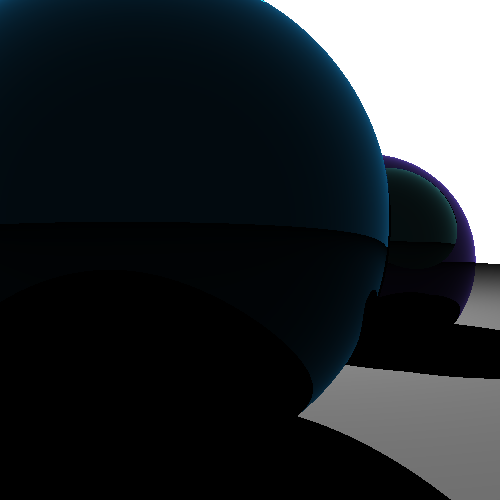

In [14]:
showscene(rand(scene))

Observation #

In [15]:
"Some example spheres which should create actual image"
function obs_scene()
  scene = [msphere(Point(0.0, -10004, -20), 10000.0, Vec3(0.20, 0.20, 0.20), 0.0, 0.0, Vec3(0.0, 0.0, 0.0)),
           msphere(Point(0.0, 0.0, -20), 4.0, Vec3(1.0, 0.32, 0.36), 1.0, 0.5, zeros(Vec3)),
           msphere(Point(5.0, 1.0, -15), 2.0, Vec3(0.90, 0.76, 0.46), 1.0, 0.0, zeros(Vec3)),
           msphere(Point(5.0, 0.0, -25), 3.0, Vec3(0.65, 0.77, 0.970), 1.0, 0.0, zeros(Vec3)),
           msphere(Point(-5.5,      0, -15), 3.0, Vec3(0.90, 0.90, 0.90), 1.0, 0.0, zeros(Vec3)),
           msphere(Point(0.0, 20.0, -30), 3.0, zeros(Vec3), 0.0, 0.0, Vec3(3.0, 3.0, 3.0))]
  RayTrace.ListScene(scene)
end

const img_obs = rendersquare(obs_scene())

Img{Array{GeometryTypes.Vec{3,Float64},2}}(GeometryTypes.Vec{3,Float64}[[1.0, 1.0, 1.0] [1.0, 1.0, 1.0] … [0.437706, 0.437706, 0.437706] [0.437132, 0.437132, 0.437132]; [1.0, 1.0, 1.0] [1.0, 1.0, 1.0] … [0.437764, 0.437764, 0.437764] [0.437189, 0.437189, 0.437189]; … ; [1.0, 1.0, 1.0] [1.0, 1.0, 1.0] … [0.437648, 0.437648, 0.437648] [0.437075, 0.437075, 0.437075]; [1.0, 1.0, 1.0] [1.0, 1.0, 1.0] … [0.437589, 0.437589, 0.437589] [0.437018, 0.437018, 0.437018]])

Show the obseration

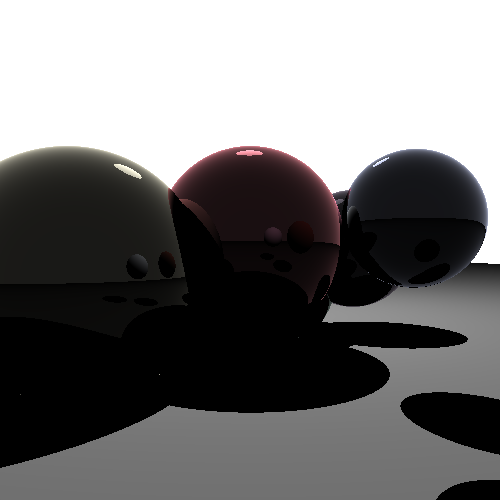

In [16]:
showscene(obs_scene())

function sampleposterior(n = 1000)
  samples = rand(scene, img ==ₛ img_obs, n; alg = SSMH)
end

scenesamples = sampleposterior()
showscene(scenesamples[end])

function sampleposterior_noi(n = 50000; noi = false, alg = SSMH, gamma = 1.0, kwargs...)
  logdir = Random.randstring()
  writer = Tensorboard.SummaryWriter(logdir)
  noipred = Omega.lift(nointersect)(scene)
  obspred = img ==ₛ img_obs
  pred = noi ? (gamma * noipred) & obspred : obspred
  samples = rand(scene, pred, n; cb = cb, alg = alg, kwargs...)
  samples
end#-
*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*